In [1]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

df = pd.read_excel("/content/drive/MyDrive/tnew.xlsx")
df = df.loc[:, ~df.columns.duplicated()]

# Time transformation
time_cols = ["Inbound Handle Time","Outbound Handle Time","Talk Time","Hold Time","Wait Time","Login Time","ACW Time"]
for col in time_cols:
    df[col] = pd.to_timedelta(df[col], errors="coerce").dt.total_seconds()

# Call volumes
df["Inbound Handled"] = df["Inbound Handled"].fillna(0)
df["Outbound Handled"] = df["Outbound Handled"].fillna(0)
df["Total Calls"] = df["Inbound Handled"] + df["Outbound Handled"]

# Performance metrics
df["AHT"] = (df["Inbound Handle Time"] + df["Outbound Handle Time"]) / df["Total Calls"].replace(0, np.nan)
df["Occupancy %"] = ((df["Talk Time"] + df["Hold Time"] + df["ACW Time"]) / df["Login Time"]) * 100
df["ACW %"] = (df["ACW Time"] / df["Handle Time"].replace(0, np.nan)) * 100
df["SLA %"] = (df["In SLA"] / df["Total Calls"].replace(0, np.nan)) * 100
df["Complaint_Flag"] = np.where(df["Complaint"].notnull(), 1, 0)

# Transcript sentiment (numeric score)
df["Transcript_Sentiment"] = df["Transcript"].dropna().apply(lambda x: TextBlob(str(x)).sentiment.polarity)

# Normalize Sentiment Class
df["Sentiment_Class"] = df["Sentiment"].str.lower().map({
    "positive":"Positive","negative":"Negative","neutral":"Neutral"
})

# Disposition normalization
df["Disposition_Clean"] = df["Disposition"].str.strip().str.title()

# Extract top keywords globally
vectorizer = CountVectorizer(stop_words="english", max_features=20)
X = vectorizer.fit_transform(df["Transcript"].dropna())
keywords = vectorizer.get_feature_names_out()
df["Top_Keywords"] = ",".join(keywords)

df.to_csv("clean_agent_transcripts.csv", index=False)


In [15]:
import pandas as pd
import numpy as np
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer

# ===============================
# 1. Load and Basic Cleaning
# ===============================
df = pd.read_excel("/content/drive/MyDrive/tnew.xlsx")

# Drop duplicate columns (Handled.1, etc.)
df = df.loc[:, ~df.columns.duplicated()]

# ===============================
# 2. Date Conversion
# ===============================
# Ensure Date column is proper datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# Create derived time features
df["YearMonth"] = df["Date"].dt.to_period("M").astype(str)   # e.g., 2025-09
df["Week"] = df["Date"].dt.to_period("W").astype(str)        # e.g., 2025-09-22/2025-09-28

# ===============================
# 3. Ensure Numeric for Time Metrics
# (values already in SECONDS, no timedelta conversion needed)
# ===============================
time_cols = [
    "Inbound Handle Time", "Outbound Handle Time", "Talk Time",
    "Hold Time", "Wait Time", "Login Time", "ACW Time"
]

for col in time_cols:
    df[col] = pd.to_numeric(df[col], errors="coerce")

# ===============================
# 4. Call Volumes
# ===============================
df["Inbound Handled"] = df["Inbound Handled"].fillna(0)
df["Outbound Handled"] = df["Outbound Handled"].fillna(0)
df["Total Calls"] = df["Inbound Handled"] + df["Outbound Handled"]

# ===============================
# 5. Agent Performance KPIs
# ===============================
df["AHT"] = (df["Inbound Handle Time"] + df["Outbound Handle Time"]) / df["Total Calls"].replace(0, np.nan)
df["Occupancy %"] = ((df["Talk Time"] + df["Hold Time"] + df["ACW Time"]) / df["Login Time"]) * 100
df["ACW %"] = (df["ACW Time"] / df["Handle Time"].replace(0, np.nan)) * 100
df["SLA %"] = (df["In SLA"] / df["Total Calls"].replace(0, np.nan)) * 100

# ===============================
# 6. Complaint Handling (Simple Flag)
# ===============================
df["Complaint_Flag"] = np.where(df["Complaint"].notnull(), 1, 0)

# ===============================
# 7. Transcript-Based Features
# ===============================

# Numeric Sentiment Score (-1 to +1)
df["Transcript_Sentiment"] = df["Transcript"].dropna().apply(
    lambda x: TextBlob(str(x)).sentiment.polarity
)

# Standardize Sentiment Labels (already in your file)
df["Sentiment_Class"] = df["Sentiment"].astype(str).str.lower().map({
    "positive": "Positive",
    "negative": "Negative",
    "neutral": "Neutral"
})

# Normalize Disposition text
df["Disposition_Clean"] = df["Disposition"].astype(str).str.strip().str.title()

# Keyword Extraction (Top 20 words across transcripts)
vectorizer = CountVectorizer(stop_words="english", max_features=20)
X = vectorizer.fit_transform(df["Transcript"].dropna())
keywords = vectorizer.get_feature_names_out()
df["Top_Keywords"] = ",".join(keywords)

# ===============================
# 8. Export Clean Dataset
# ===============================
df.to_csv("clean_agent_transcripts.csv", index=False)

print("✅ Preprocessing complete. File saved as 'clean_agent_transcripts.csv'")


✅ Preprocessing complete. File saved as 'clean_agent_transcripts.csv'


/tmp/ipython-input-1762359697.py:42: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agent_kpis, x="Agent Name", y="Total Calls", palette="Blues_d")


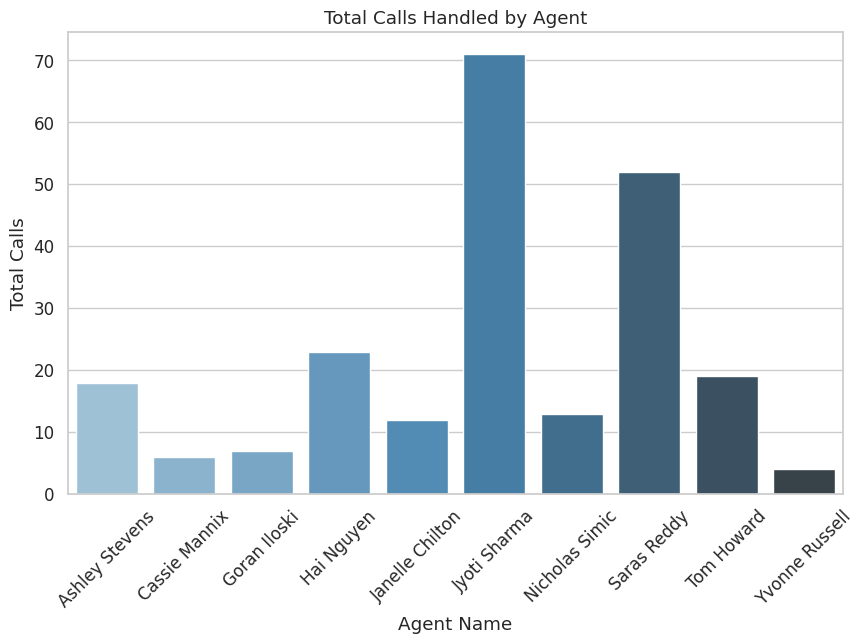

/tmp/ipython-input-1762359697.py:49: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agent_kpis, x="Agent Name", y="AHT", palette="viridis")


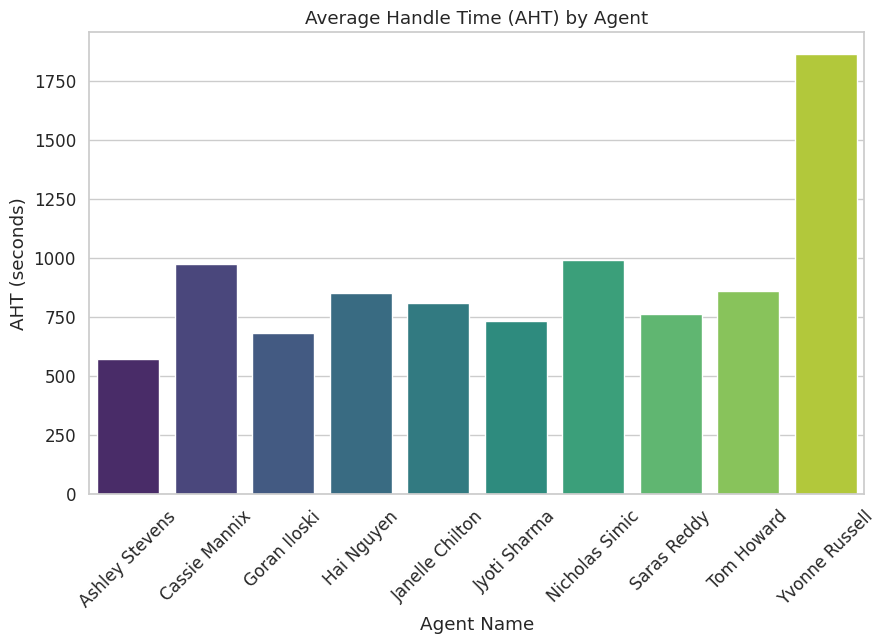

ValueError: The name Agent Name occurs multiple times, use a level number

<Figure size 1000x600 with 0 Axes>

In [18]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# ===================================
# 1. Load Data
# ===================================
# Cleaned transcripts data
#df = pd.read_csv("/content/clean_agent_transcripts_v1.csv")

# KPI Reference Table (for documentation, not used directly in calcs)
#kpi_table = pd.read_excel("Transformation_KPI_Table.xlsx")

# Ensure Date is datetime
df["Date"] = pd.to_datetime(df["Date"], errors="coerce")

# ===================================
# 2. Aggregate Agent KPIs
# ===================================
agent_kpis = df.groupby("Agent Name").agg({
    "Total Calls": "sum",
    "AHT": "mean",
    "Occupancy %": "mean",
    "ACW %": "mean",
    "SLA %": "mean",
    "Quality Score": "mean",
    "Complaint_Flag": "mean",
    "Transcript_Sentiment": "mean"
}).reset_index()

agent_kpis.rename(columns={"Complaint_Flag": "Complaint Rate",
                           "Transcript_Sentiment": "Avg Sentiment"}, inplace=True)

# ===================================
# 3. Visualizations
# ===================================

# ----- 3.1 Calls handled per agent -----
plt.figure(figsize=(10,6))
sns.barplot(data=agent_kpis, x="Agent Name", y="Total Calls", palette="Blues_d")
plt.title("Total Calls Handled by Agent")
plt.xticks(rotation=45)
plt.show()

# ----- 3.2 AHT comparison -----
plt.figure(figsize=(10,6))
sns.barplot(data=agent_kpis, x="Agent Name", y="AHT", palette="viridis")
plt.title("Average Handle Time (AHT) by Agent")
plt.xticks(rotation=45)
plt.ylabel("AHT (seconds)")
plt.show()

# ----- 3.3 Occupancy heatmap -----
plt.figure(figsize=(10,6))
sns.heatmap(agent_kpis.pivot(index="Agent Name", values="Occupancy %", columns="Agent Name"),
            cmap="RdYlGn", cbar=True, annot=False)
plt.title("Agent Occupancy % (Heatmap)")
plt.show()

# ----- 3.4 Complaint rate -----
plt.figure(figsize=(10,6))
sns.barplot(data=agent_kpis, x="Agent Name", y="Complaint Rate", palette="Reds")
plt.title("Complaint Rate by Agent")
plt.xticks(rotation=45)
plt.ylabel("Complaint Rate (%)")
plt.show()

# ----- 3.5 Sentiment distribution -----
plt.figure(figsize=(10,6))
sns.boxplot(data=df, x="Agent Name", y="Transcript_Sentiment")
plt.title("Transcript Sentiment Distribution per Agent")
plt.xticks(rotation=45)
plt.ylabel("Sentiment Score (-1 to 1)")
plt.show()

# ----- 3.6 SLA performance -----
plt.figure(figsize=(10,6))
sns.lineplot(data=df.groupby(["Date","Agent Name"])["SLA %"].mean().reset_index(),
             x="Date", y="SLA %", hue="Agent Name", marker="o")
plt.title("SLA % Trend Over Time (Agent-wise)")
plt.xticks(rotation=45)
plt.show()

# ----- 3.7 Quality Score vs Sentiment (scatter) -----
plt.figure(figsize=(8,6))
sns.scatterplot(data=agent_kpis, x="Quality Score", y="Avg Sentiment", hue="Agent Name", s=120)
plt.title("Agent Quality Score vs Avg Sentiment")
plt.xlabel("Avg Quality Score")
plt.ylabel("Avg Sentiment (-1 to 1)")
plt.axhline(0, color="gray", linestyle="--")
plt.show()

# ----- 3.8 Word Cloud (Agent-wise) -----
stopwords = set(["um","uh","yes","no","okay","ok","thank","thanks",
                 "please","hello","right","just","like","can","would","also","one","get"])

for agent in df["Agent Name"].unique():
    text = " ".join(df[df["Agent Name"]==agent]["Transcript"].dropna().astype(str).tolist())
    if text.strip() == "":
        continue
    wc = WordCloud(width=800, height=400, background_color="white",
                   stopwords=stopwords, max_words=100, colormap="plasma").generate(text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Agent: {agent}")
    plt.show()

# ----- 3.9 Correlation Heatmap -----
plt.figure(figsize=(8,6))
sns.heatmap(agent_kpis.corr(), annot=True, cmap="coolwarm", fmt=".2f")
plt.title("Correlation between Agent KPIs")
plt.show()

# ===================================
# 4. Export Agent KPI Summary
# ===================================
agent_kpis.to_excel("Agent_KPI_Summary.xlsx", index=False)
print("✅ KPI visualizations generated and Agent KPI summary exported as Agent_KPI_Summary.xlsx")


In [3]:
# ======================================
# 1. Load Clean Data (from preprocessing)
# ======================================
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

df = pd.read_csv("/content/clean_agent_transcripts_v1.csv")

# Set plot style
sns.set(style="whitegrid", palette="muted", font_scale=1.1)


/tmp/ipython-input-485187912.py:5: FutureWarning: 

The `ci` parameter is deprecated. Use `errorbar=None` for the same effect.

  sns.barplot(data=df, x="Agent Name", y="AHT", ci=None)


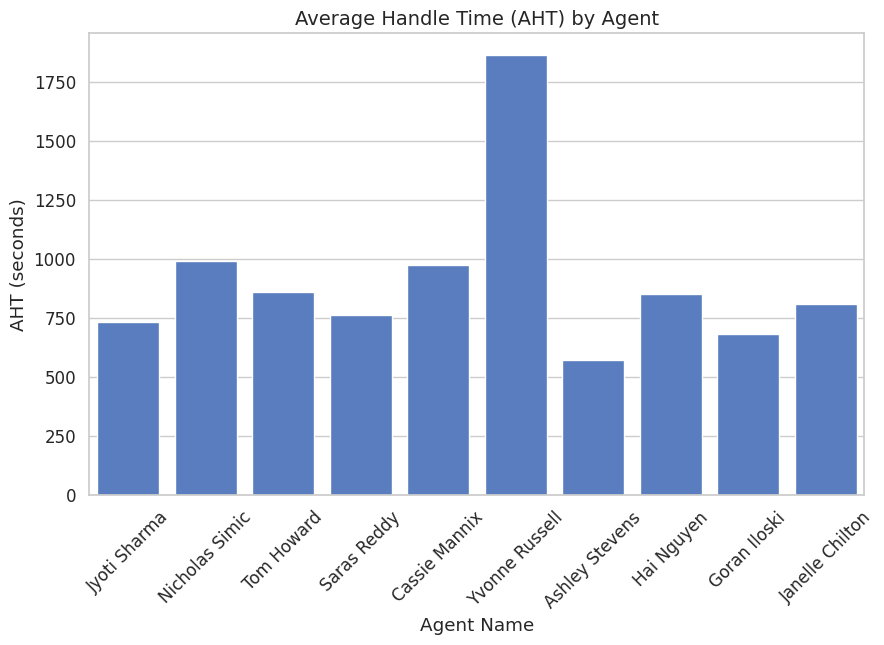

In [4]:
# ======================================
# 2. Agent Performance – AHT by Agent
# ======================================
plt.figure(figsize=(10,6))
sns.barplot(data=df, x="Agent Name", y="AHT", ci=None)
plt.title("Average Handle Time (AHT) by Agent", fontsize=14)
plt.xticks(rotation=45)
plt.ylabel("AHT (seconds)")
plt.show()


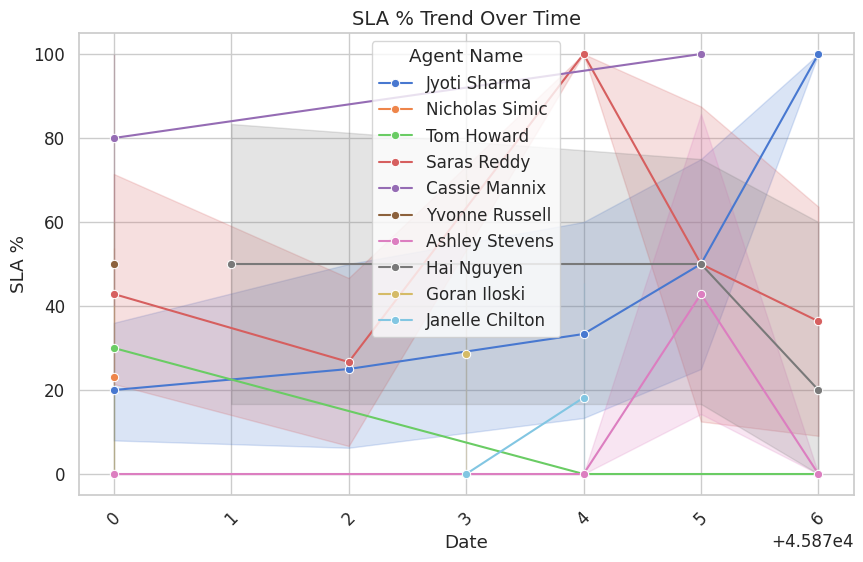

In [5]:
# ======================================
# 3. SLA % Trend Over Time
# ======================================
plt.figure(figsize=(10,6))
sns.lineplot(data=df, x="Date", y="SLA %", hue="Agent Name", marker="o")
plt.title("SLA % Trend Over Time", fontsize=14)
plt.ylabel("SLA %")
plt.xticks(rotation=45)
plt.show()


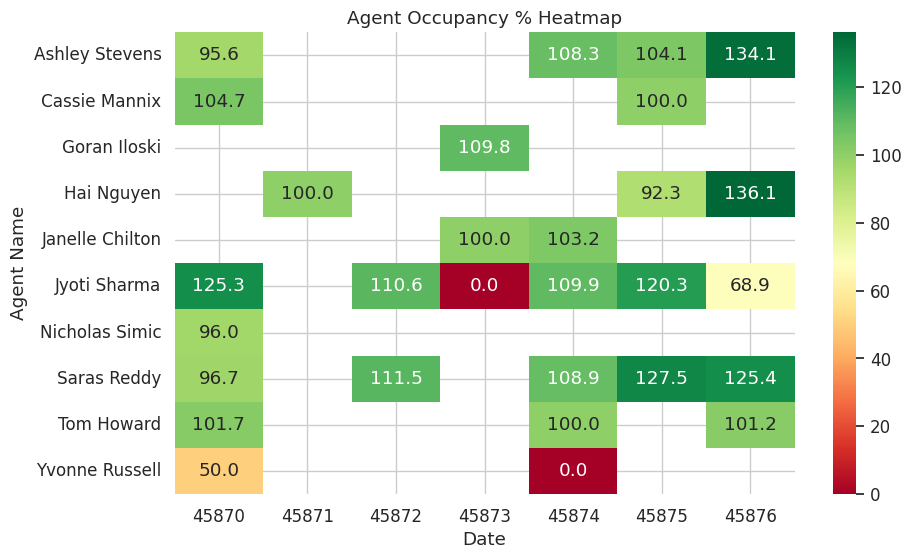

In [6]:
# ======================================
# 4. Occupancy % by Agent
# ======================================
plt.figure(figsize=(10,6))
sns.heatmap(df.pivot_table(values="Occupancy %", index="Agent Name", columns="Date"),
            cmap="RdYlGn", annot=True, fmt=".1f")
plt.title("Agent Occupancy % Heatmap")
plt.show()


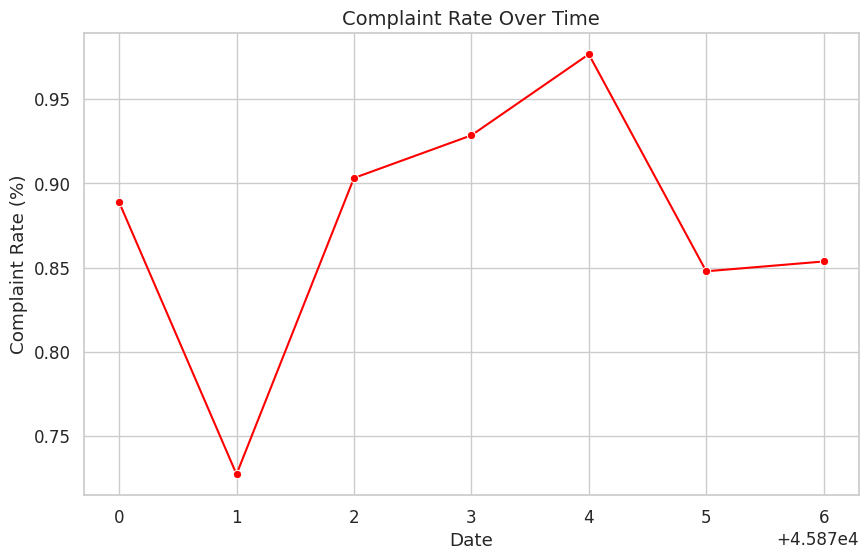

In [7]:
# ======================================
# 5. Complaint Rate Over Time
# ======================================
complaint_trend = df.groupby("Date")["Complaint_Flag"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=complaint_trend, x="Date", y="Complaint_Flag", marker="o", color="red")
plt.title("Complaint Rate Over Time", fontsize=14)
plt.ylabel("Complaint Rate (%)")
plt.show()


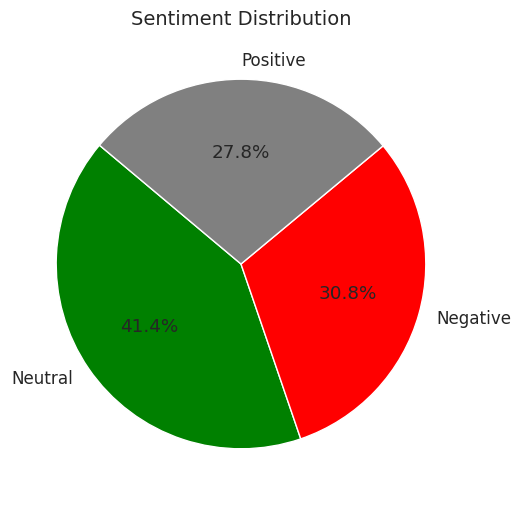

In [8]:
# ======================================
# 6. Sentiment Distribution (Pie Chart)
# ======================================
sentiment_counts = df["Sentiment_Class"].value_counts()

plt.figure(figsize=(6,6))
plt.pie(sentiment_counts, labels=sentiment_counts.index, autopct="%1.1f%%", startangle=140,
        colors=["green","red","gray"])
plt.title("Sentiment Distribution", fontsize=14)
plt.show()


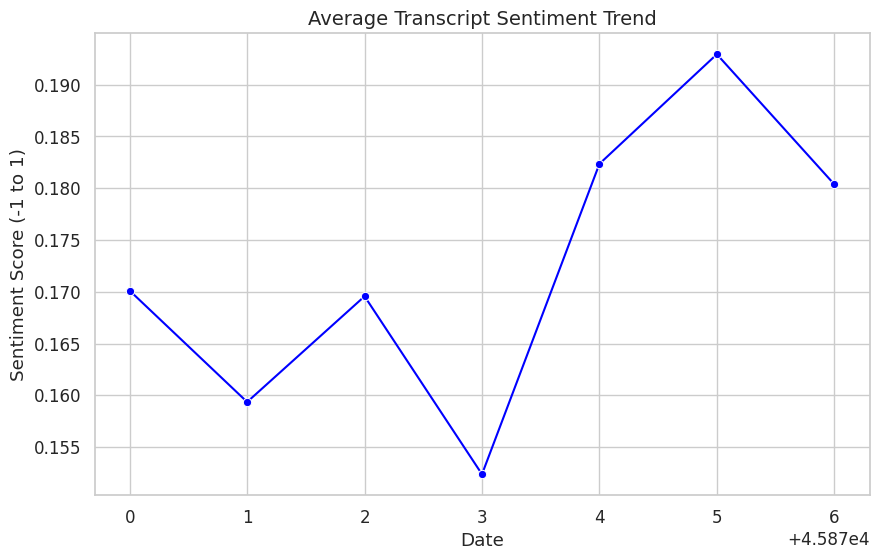

In [9]:
# ======================================
# 7. Average Transcript Sentiment Trend
# ======================================
sentiment_trend = df.groupby("Date")["Transcript_Sentiment"].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=sentiment_trend, x="Date", y="Transcript_Sentiment", marker="o", color="blue")
plt.title("Average Transcript Sentiment Trend", fontsize=14)
plt.ylabel("Sentiment Score (-1 to 1)")
plt.show()


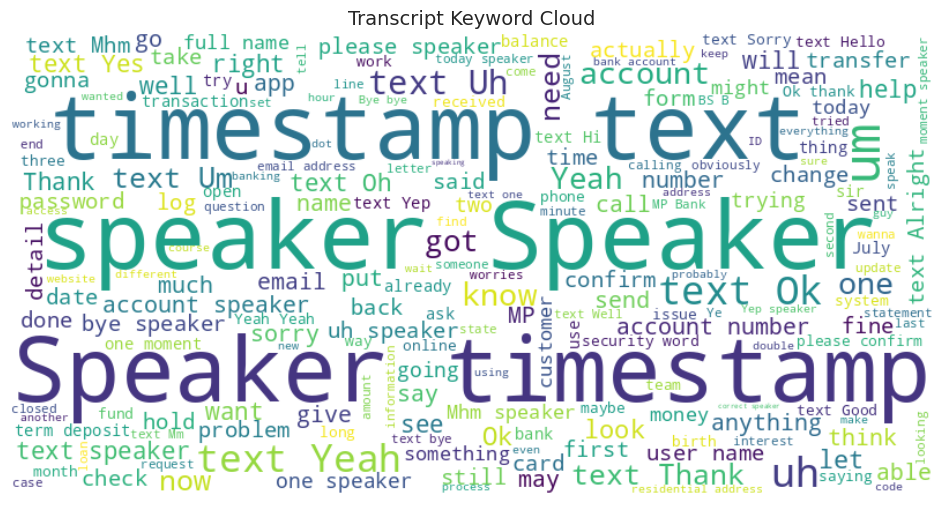

In [10]:
# ======================================
# 8. Word Cloud – Top Keywords in Transcripts
# ======================================
text = " ".join(df["Transcript"].dropna().astype(str))

wordcloud = WordCloud(width=800, height=400, background_color="white", colormap="viridis").generate(text)

plt.figure(figsize=(12,6))
plt.imshow(wordcloud, interpolation="bilinear")
plt.axis("off")
plt.title("Transcript Keyword Cloud", fontsize=14)
plt.show()


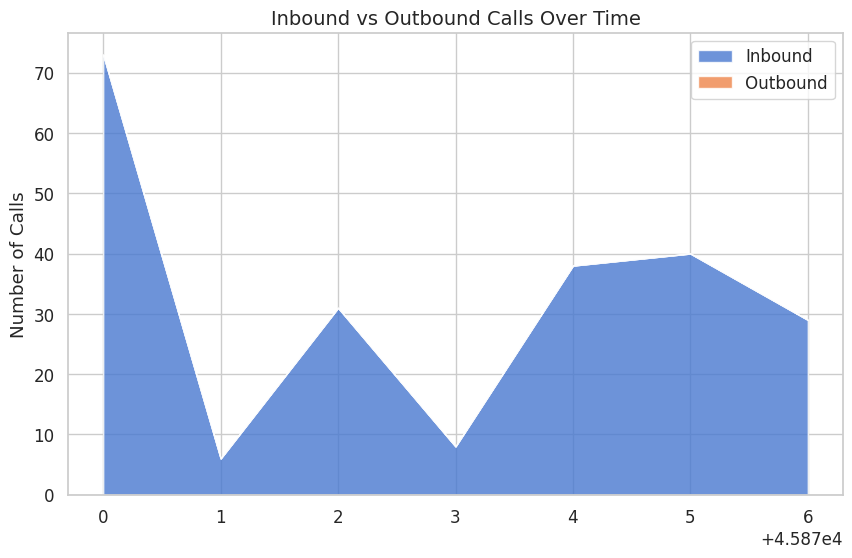

In [11]:
# ======================================
# 9. Inbound vs Outbound Calls
# ======================================
df_grouped = df.groupby("Date")[["Inbound Handled","Outbound Handled"]].sum().reset_index()

plt.figure(figsize=(10,6))
plt.stackplot(df_grouped["Date"], df_grouped["Inbound Handled"], df_grouped["Outbound Handled"],
              labels=["Inbound","Outbound"], alpha=0.8)
plt.title("Inbound vs Outbound Calls Over Time", fontsize=14)
plt.ylabel("Number of Calls")
plt.legend()
plt.show()


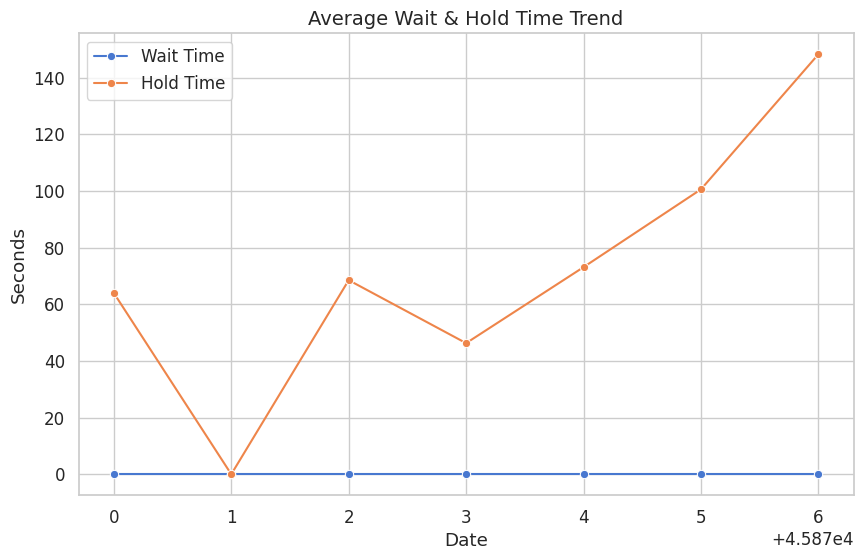

In [12]:
# ======================================
# 10. Wait and Hold Time Trend
# ======================================
time_trend = df.groupby("Date")[["Wait Time","Hold Time"]].mean().reset_index()

plt.figure(figsize=(10,6))
sns.lineplot(data=time_trend, x="Date", y="Wait Time", marker="o", label="Wait Time")
sns.lineplot(data=time_trend, x="Date", y="Hold Time", marker="o", label="Hold Time")
plt.title("Average Wait & Hold Time Trend", fontsize=14)
plt.ylabel("Seconds")
plt.legend()
plt.show()


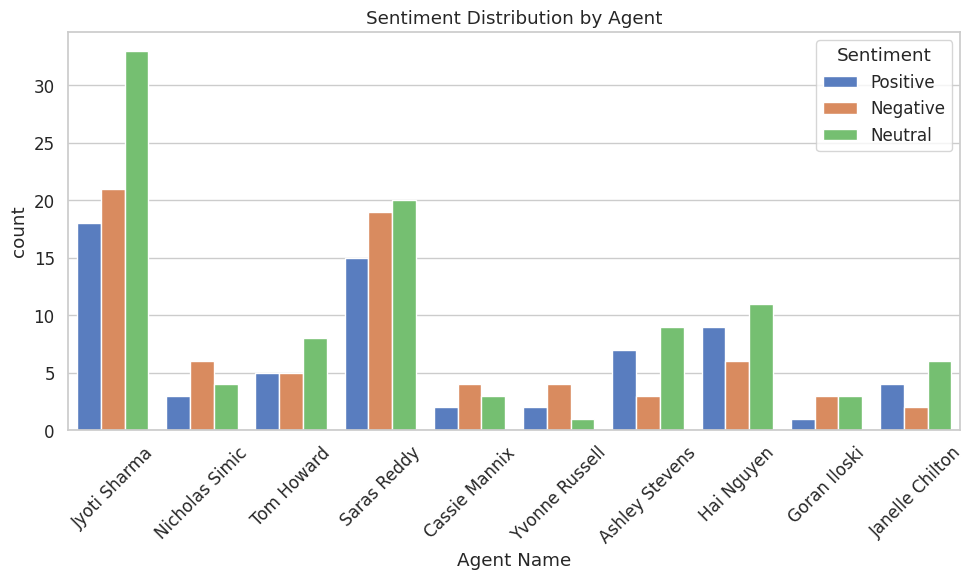

/tmp/ipython-input-1160698347.py:36: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(data=agent_sent, x="Transcript_Sentiment", y="Agent Name", palette="viridis")


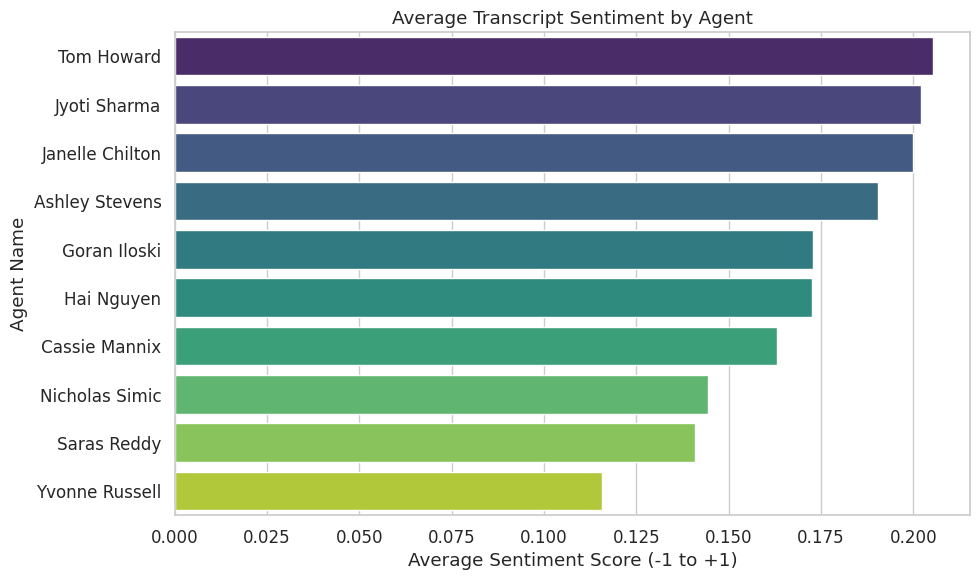

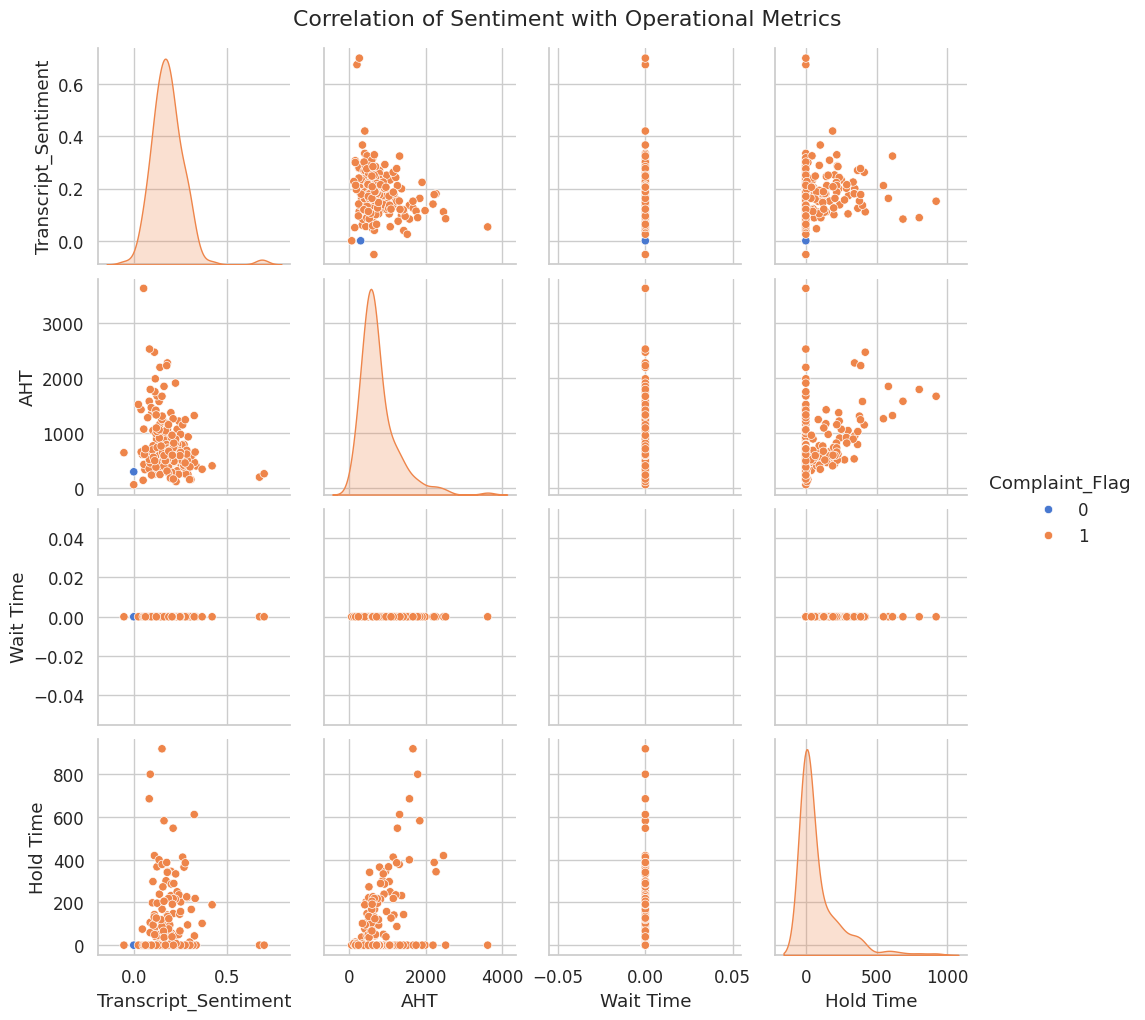

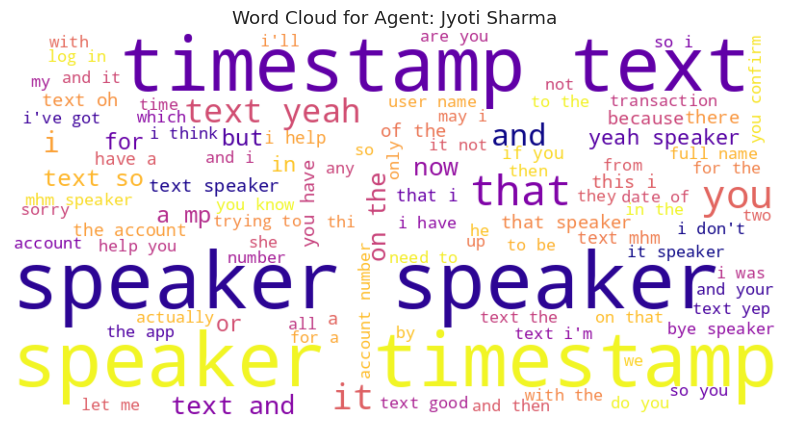

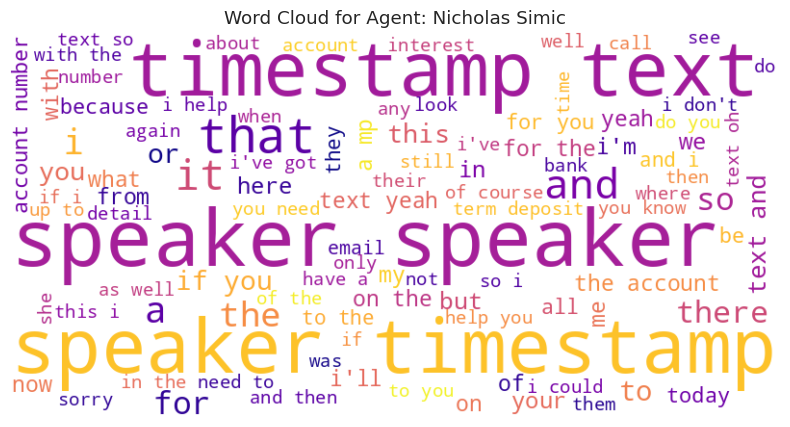

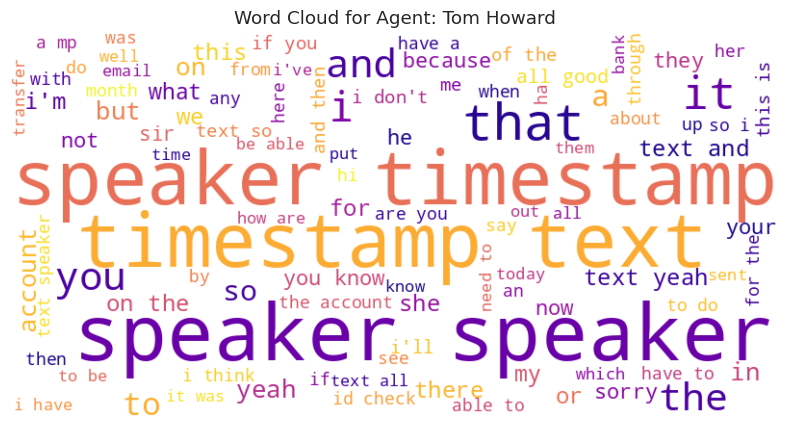

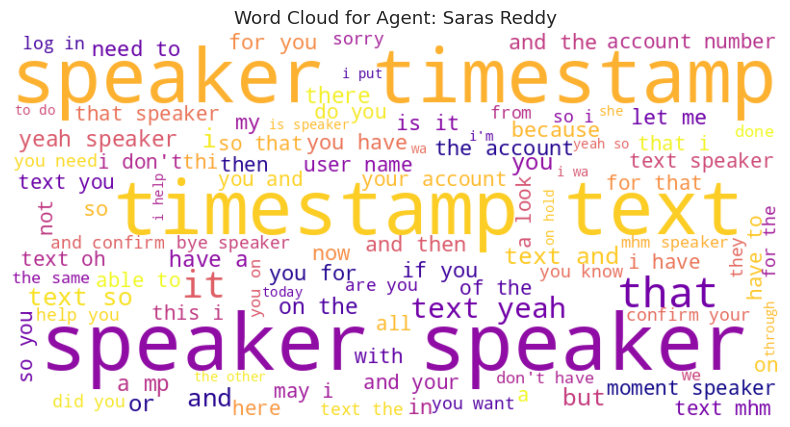

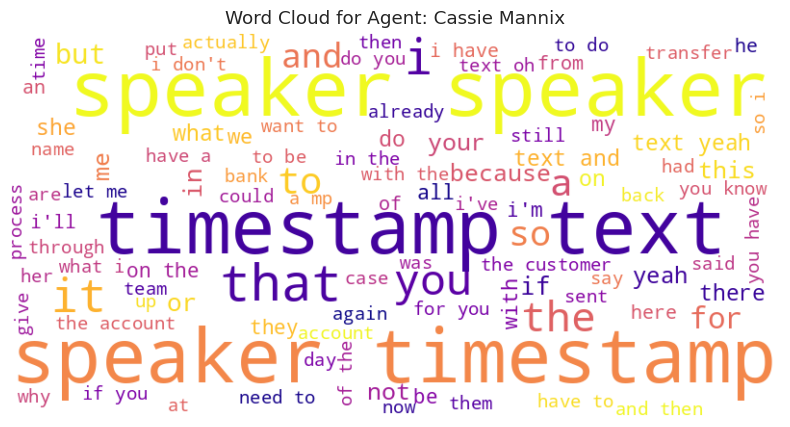

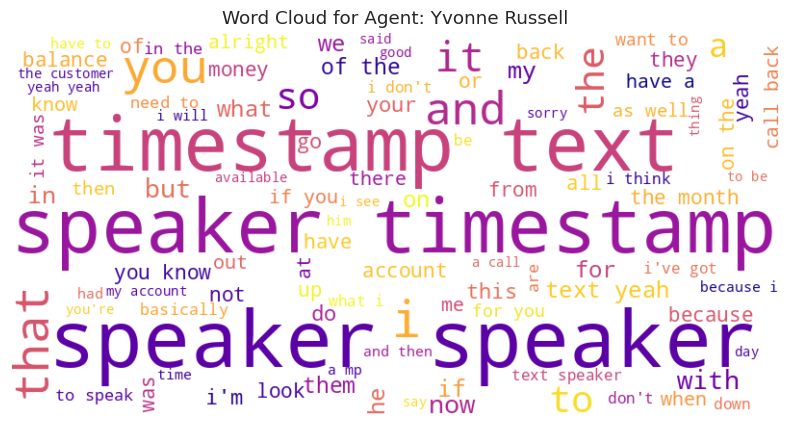

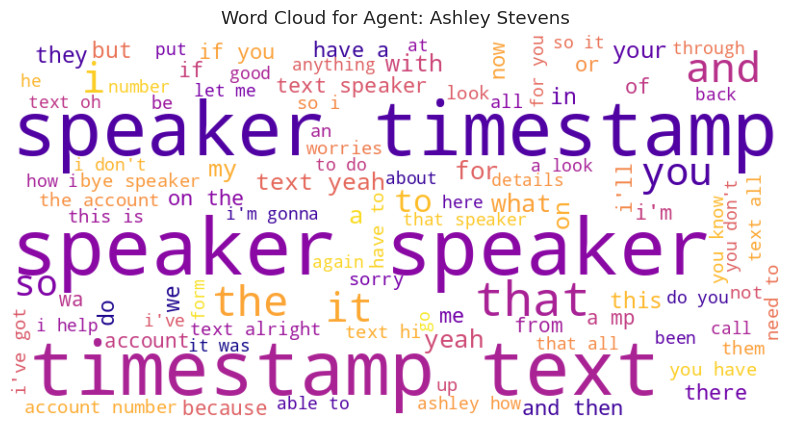

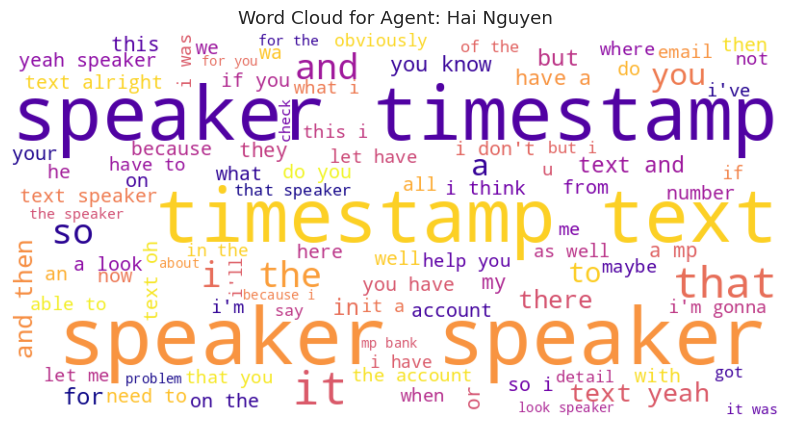

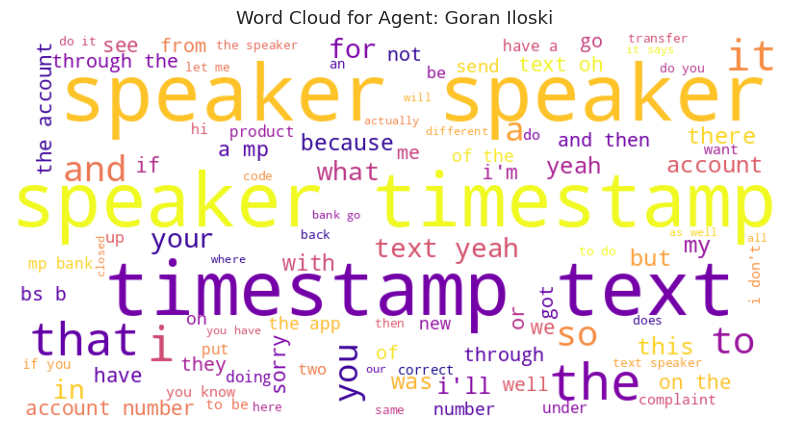

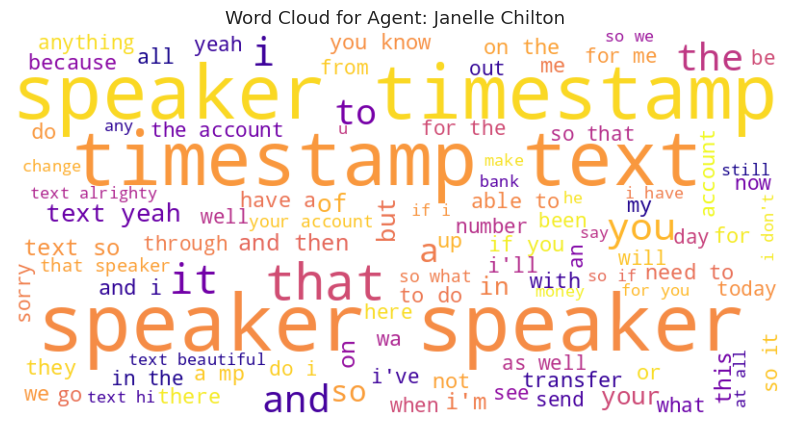

Topic 1: got, user, oh, log, number, yes, mp, app, ve, password
Topic 2: balance, need, transfer, month, let, got, yes, know, ve, like
Topic 3: look, think, number, mp, bank, got, like, don, ve, know
Topic 4: send, mp, address, know, form, yes, ve, need, email, number
Topic 5: sorry, bye, ve, got, yes, like, number, good, transaction, card


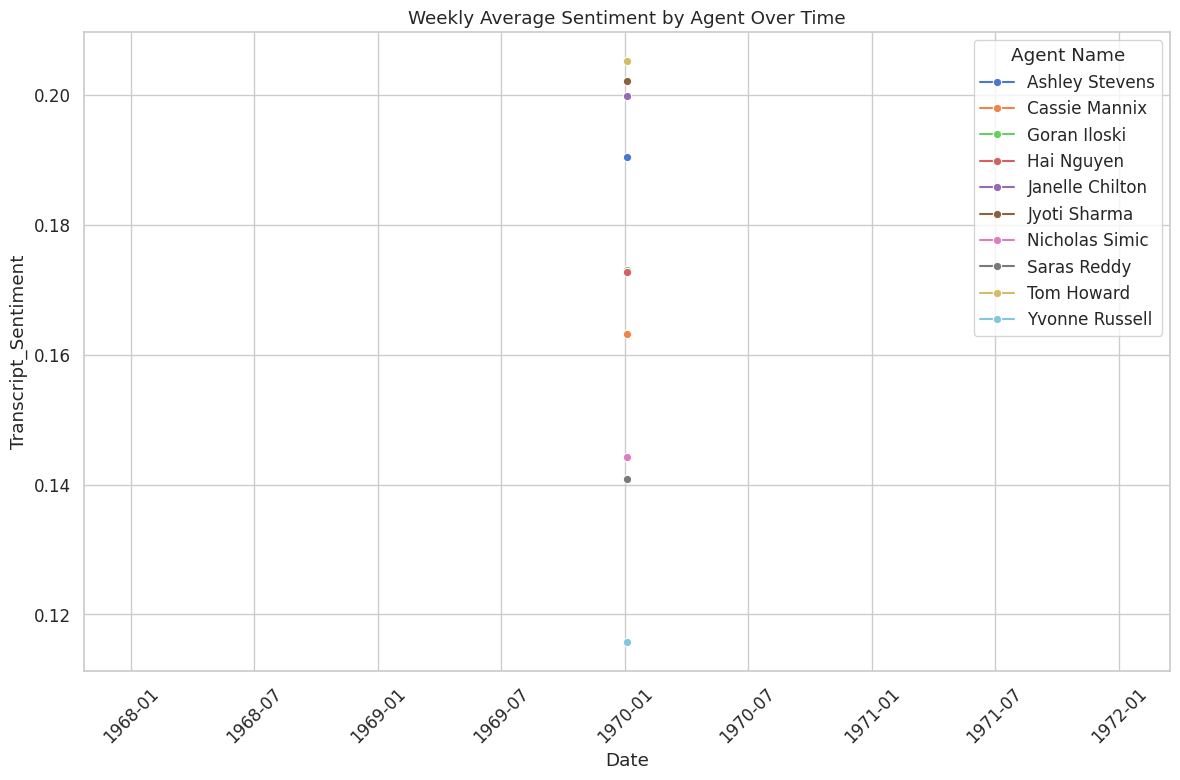

In [13]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
from textblob import TextBlob
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.decomposition import LatentDirichletAllocation

# Load cleaned data
#df = pd.read_csv("clean_agent_transcripts.csv")

# Optional: restrict to non-null transcripts
df_trans = df.dropna(subset=["Transcript"])

# List of stop / unwanted words for word cloud
unwanted = set(["um", "uh", "yes", "no", "okay", "ok", "thank", "thanks",
                "please", "hello", "right", "just", "like", "can", "would", "also", "one", "get"])

# ================
# Agent-wise Sentiment Distribution
# ================
plt.figure(figsize=(10,6))
sns.countplot(data=df, x="Agent Name", hue="Sentiment_Class")
plt.title("Sentiment Distribution by Agent")
plt.xticks(rotation=45)
plt.legend(title="Sentiment")
plt.tight_layout()
plt.show()

# ================
# Agent-wise Average Transcript Sentiment
# ================
agent_sent = df.groupby("Agent Name")["Transcript_Sentiment"].mean().reset_index().sort_values("Transcript_Sentiment", ascending=False)
plt.figure(figsize=(10,6))
sns.barplot(data=agent_sent, x="Transcript_Sentiment", y="Agent Name", palette="viridis")
plt.title("Average Transcript Sentiment by Agent")
plt.xlabel("Average Sentiment Score (-1 to +1)")
plt.tight_layout()
plt.show()

# ================
# Correlation: Sentiment vs AHT, WaitTime, etc.
# ================
# select a subset
corr_df = df[["Transcript_Sentiment", "AHT", "Wait Time", "Hold Time", "Complaint_Flag"]].dropna()
sns.pairplot(corr_df, vars=["Transcript_Sentiment", "AHT", "Wait Time", "Hold Time"], hue="Complaint_Flag", diag_kind="kde")
plt.suptitle("Correlation of Sentiment with Operational Metrics", y=1.02)
plt.show()

# ================
# Word Cloud per Agent (interactive or loop)
# ================
agents = df["Agent Name"].unique()
for agent in agents:
    texts = " ".join(df_trans[df_trans["Agent Name"] == agent]["Transcript"].astype(str).tolist())
    if not texts.strip():
        continue
    # filter unwanted words
    # lower-case and simple cleaning
    words = [w for w in texts.lower().split() if w not in unwanted]
    filtered_text = " ".join(words)
    wc = WordCloud(width=800, height=400, background_color="white",
                   stopwords=unwanted, max_words=100, colormap="plasma").generate(filtered_text)
    plt.figure(figsize=(10,5))
    plt.imshow(wc, interpolation="bilinear")
    plt.axis("off")
    plt.title(f"Word Cloud for Agent: {agent}")
    plt.show()

# ================
# Topic Modeling (optional) — to find common themes
# ================
# Prepare corpus
vectorizer = CountVectorizer(stop_words="english", max_df=0.9, min_df=10)
X = vectorizer.fit_transform(df_trans["Transcript"])
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X)

# show top words per topic
terms = vectorizer.get_feature_names_out()
for idx, topic in enumerate(lda.components_):
    top = [terms[i] for i in topic.argsort()[-10:]]
    print(f"Topic {idx+1}: {', '.join(top)}")

# ================
# Trend of Agent-wise Sentiment Over Time
# ================
df_time = df.copy()
df_time["Date"] = pd.to_datetime(df_time["Date"])
agent_time = df_time.groupby(["Agent Name", pd.Grouper(key="Date", freq="W")])["Transcript_Sentiment"].mean().reset_index()

plt.figure(figsize=(12,8))
sns.lineplot(data=agent_time, x="Date", y="Transcript_Sentiment", hue="Agent Name", marker="o")
plt.title("Weekly Average Sentiment by Agent Over Time")
plt.xticks(rotation=45)
plt.tight_layout()
plt.show()
